<a href="https://colab.research.google.com/github/bharathbolla/UoA-Capstone-I/blob/main/Bharath_NN_Assignment_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img

In [ ]:
!nvidia-smi

Mon Jan 16 18:54:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    51W / 400W |  17924MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, BatchNormalization, Dropout, MaxPooling2D, ReLU, AveragePooling2D, Flatten, ZeroPadding2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, save_model, load_model

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/skin_cancer_data/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/skin_cancer_data/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

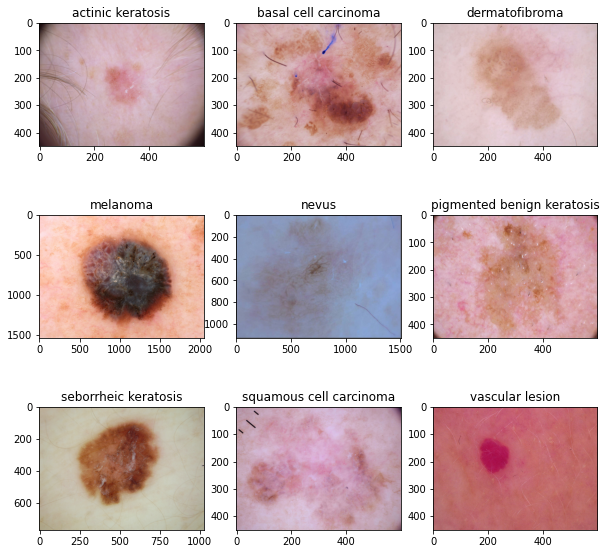

In [ ]:
### your code goes here, you can use training or validation data to visualize
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
num_classes = 9
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())



model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))




### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 re_lu_14 (ReLU)             (None, 180, 180, 16)      0         
                                                                 
 batch_normalization_14 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 re_lu_15 (ReLU)             (None, 180, 180, 32)      0         
                                                      

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 11s 60ms/step - loss: 1.6885 - accuracy: 0.3930 - val_loss: 4.8725 - val_accuracy: 0.1084
Epoch 2/20
169/169 [==============================] - 10s 60ms/step - loss: 1.3970 - accuracy: 0.4826 - val_loss: 2.5035 - val_accuracy: 0.2264
Epoch 3/20
169/169 [==============================] - 11s 60ms/step - loss: 1.2677 - accuracy: 0.5243 - val_loss: 2.3624 - val_accuracy: 0.2687
Epoch 4/20
169/169 [==============================] - 10s 59ms/step - loss: 1.1961 - accuracy: 0.5443 - val_loss: 1.8776 - val_accuracy: 0.3705
Epoch 5/20
169/169 [==============================] - 10s 59ms/step - loss: 1.0864 - accuracy: 0.5931 - val_loss: 2.1176 - val_accuracy: 0.3794
Epoch 6/20
169/169 [==============================] - 10s 59ms/step - loss: 1.0159 - accuracy: 0.6142 - val_loss: 1.3692 - val_accuracy: 0.4996
Epoch 7/20
169/169 [==============================] - 10s 60ms/step - loss: 0.9157 - accuracy: 0.6541 - val_loss: 1.4393 - val_accuracy:

### Visualizing training results

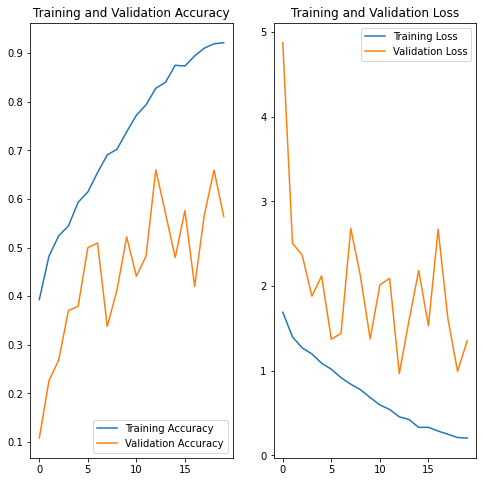

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
*   The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 25%. 

*   The training accuracy is just around 90% with 20 epochos and few filters, the model is yet to learn the many features.
*more capacity to the model might work

*  data imbalance might be causing the bais to the model.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


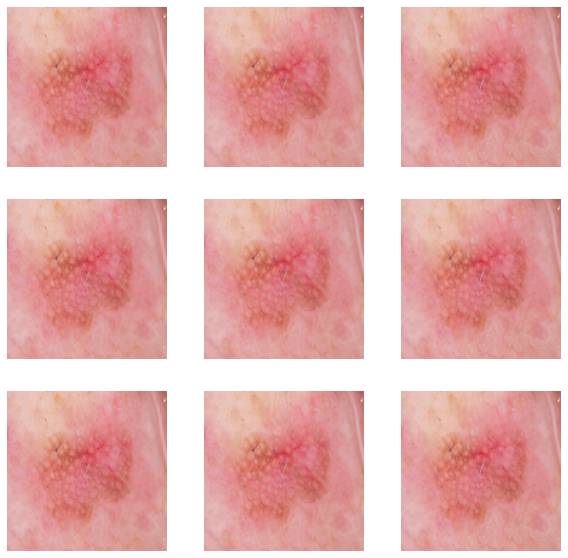

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())



model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))



### Compiling the model

In [ ]:
## Your code goes here
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 12s 61ms/step - loss: 1.7332 - accuracy: 0.3878 - val_loss: 4.0605 - val_accuracy: 0.1069
Epoch 2/20
169/169 [==============================] - 10s 59ms/step - loss: 1.3992 - accuracy: 0.4740 - val_loss: 2.6458 - val_accuracy: 0.1648
Epoch 3/20
169/169 [==============================] - 10s 60ms/step - loss: 1.2577 - accuracy: 0.5176 - val_loss: 1.6076 - val_accuracy: 0.4217
Epoch 4/20
169/169 [==============================] - 10s 59ms/step - loss: 1.1915 - accuracy: 0.5551 - val_loss: 2.0283 - val_accuracy: 0.4053
Epoch 5/20
169/169 [==============================] - 10s 60ms/step - loss: 1.0877 - accuracy: 0.5905 - val_loss: 1.9622 - val_accuracy: 0.4254
Epoch 6/20
169/169 [==============================] - 10s 59ms/step - loss: 0.9968 - accuracy: 0.6204 - val_loss: 1.9193 - val_accuracy: 0.4195
Epoch 7/20
169/169 [==============================] - 10s 59ms/step - loss: 0.9161 - accuracy: 0.6554 - val_loss: 2.3490 - val_accuracy:

### Visualizing the results

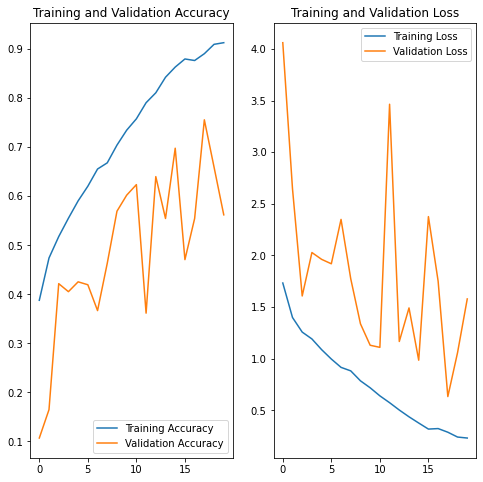

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
*   The model's overfitting reduced as droput is added. The difference between max train and test is 15% 

*   More training epochs are needed

*  data imbalance might be causing the bias to the model.
* Model is unstable as the learning curve indicates the test accuracy varies a lot

## Trying Data Augmentation

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())



model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))

In [ ]:
## Your code goes here
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 14s 69ms/step - loss: 1.7617 - accuracy: 0.3789 - val_loss: 3.2647 - val_accuracy: 0.1151
Epoch 2/20
169/169 [==============================] - 12s 71ms/step - loss: 1.5076 - accuracy: 0.4286 - val_loss: 2.3806 - val_accuracy: 0.1759
Epoch 3/20
169/169 [==============================] - 12s 68ms/step - loss: 1.4363 - accuracy: 0.4585 - val_loss: 1.6295 - val_accuracy: 0.3578
Epoch 4/20
169/169 [==============================] - 12s 68ms/step - loss: 1.3730 - accuracy: 0.4751 - val_loss: 1.5491 - val_accuracy: 0.4232
Epoch 5/20
169/169 [==============================] - 12s 69ms/step - loss: 1.3033 - accuracy: 0.5059 - val_loss: 1.7407 - val_accuracy: 0.4024
Epoch 6/20
169/169 [==============================] - 12s 69ms/step - loss: 1.2811 - accuracy: 0.5221 - val_loss: 1.9747 - val_accuracy: 0.3667
Epoch 7/20
169/169 [==============================] - 12s 70ms/step - loss: 1.2254 - accuracy: 0.5300 - val_loss: 1.8329 - val_accuracy:

### Visualizing the model performance

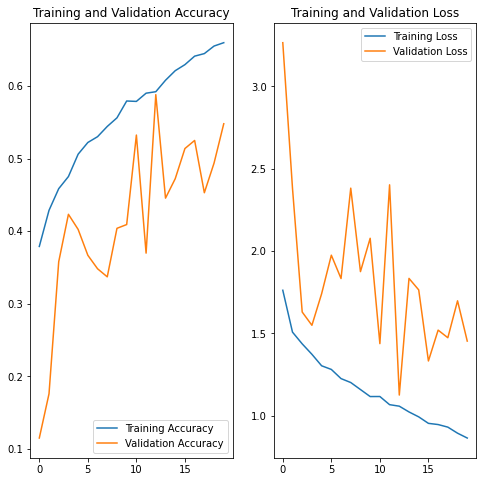

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
*  Data Augmentation has negative effect as max test accuracy is 65%

*   Different augmentation approach is needed

*  data imbalance might be causing the bias to the model.
* Model is unstable as the learning curve indicates the test accuracy varies a lot

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

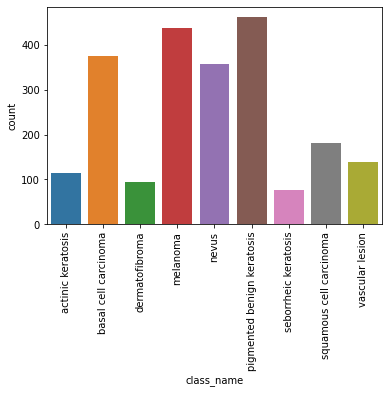

In [ ]:
## Your code goes here.
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
-> seborrheic keratosis has only 77 samples and the least number.
#### - Which classes dominate the data in terms proportionate number of samples?
-> pigmented benign keratosis class dominates the data set with highest number of samples having 462 an propotion of nearly 20% of overall sampels.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/My Drive/skin_cancer_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6600AAA60>: 100%|██████████| 500/500 [00:04<00:00, 117.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE602343E80>: 100%|██████████| 500/500 [00:04<00:00, 109.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE6020DC280>: 100%|██████████| 500/500 [00:05<00:00, 97.82 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FE60247CE80>: 100%|██████████| 500/500 [00:15<00:00, 31.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE6022B2730>: 100%|██████████| 500/500 [00:15<00:00, 31.60 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE5D2B00F10>: 100%|██████████| 500/500 [00:04<00:00, 115.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE6021B01F0>: 100%|██████████| 500/500 [00:08<00:00, 59.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5CE242EE0>: 100%|██████████| 500/500 [00:04<00:00, 114.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/skin_cancer_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE60221DE20>: 100%|██████████| 500/500 [00:04<00:00, 111.61 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(path_list))
path_list

9000


['/content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_044211dc-3823-461d-8b50-3d2535cd01b6.jpg',
 '/content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_9f027706-d268-41e7-b6c1-d7375dd75a88.jpg',
 '/content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_4267be98-42b8-4c7a-9489-a70662004ed0.jpg',
 '/content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_d25b2eda-d607-4402-8243-157f092b6725.jpg',
 '/content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_aa43c6bc-1dbe-435e-9905-3f680e719e1b.jpg',
 '/content/drive/My Drive/skin_cancer_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_9038a99e-ed33-4c04-afff-699051cacf04.jpg',
 '/content/drive/My Drive/skin_can

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))
lesion_list_new

9000


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

actinic keratosis             1000
pigmented benign keratosis    1000
dermatofibroma                1000
basal cell carcinoma          1000
vascular lesion               1000
squamous cell carcinoma       1000
nevus                         1000
seborrheic keratosis          1000
melanoma                      1000
Name: Label, dtype: int64

total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

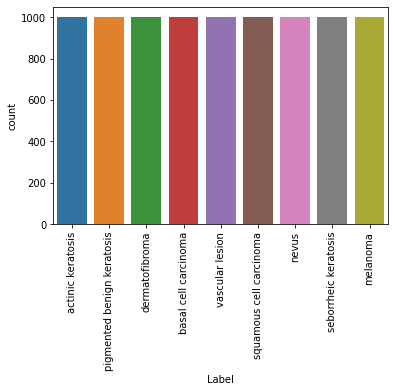

In [ ]:
num_classes = len(class_names)
total = 0
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")

sns.countplot(x=all_count)
sns.countplot(x=new_df['Label'])
plt.xticks(rotation=90)
plt.show()



So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32

img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/My Drive/skin_cancer_data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
num_classes = 9
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())



model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 re_lu_42 (ReLU)             (None, 180, 180, 16)      0         
                                                                 
 batch_normalization_42 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_43 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 re_lu_43 (ReLU)             (None, 180, 180, 32)      0         
                                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 25s 41ms/step - loss: 1.5813 - accuracy: 0.4300 - val_loss: 3.3634 - val_accuracy: 0.1153
Epoch 2/50
281/281 [==============================] - 8s 30ms/step - loss: 1.2523 - accuracy: 0.5281 - val_loss: 1.9981 - val_accuracy: 0.4117
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 1.0708 - accuracy: 0.5953 - val_loss: 2.6954 - val_accuracy: 0.3146
Epoch 4/50
281/281 [==============================] - 8s 30ms/step - loss: 0.9346 - accuracy: 0.6529 - val_loss: 1.5354 - val_accuracy: 0.4517
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.8077 - accuracy: 0.7052 - val_loss: 1.5463 - val_accuracy: 0.4526
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.6621 - accuracy: 0.7497 - val_loss: 1.4519 - val_accuracy: 0.5145
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.5405 - accuracy: 0.8038 - val_loss: 1.8721 - val_accuracy: 0.455

#### **Todo:**  Visualize the model results

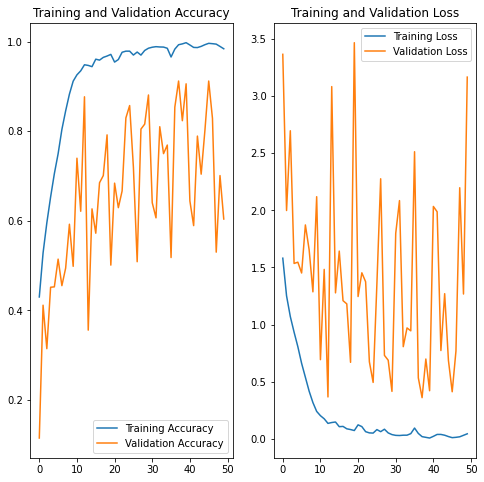

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* After rebalance/resampling of the data (that gave equal proportion of data )and raised the accuray of the mdoel to 91%. This addressed the low accuracy problem.

*  overfitting probelm is adressed and now difference between train and val set is nearly 7-8% diff. 

* with these results it's conclusive that current model with rebalanced data is the best model.



## Try with SGD but trained on weights of previous model

In [ ]:
## Your code goes here
opt = SGD(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 9s 30ms/step - loss: 0.0147 - accuracy: 0.9962 - val_loss: 0.4468 - val_accuracy: 0.9057
Epoch 2/50
281/281 [==============================] - 8s 29ms/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.4541 - val_accuracy: 0.9083
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.4233 - val_accuracy: 0.9190
Epoch 4/50
281/281 [==============================] - 8s 29ms/step - loss: 0.0127 - accuracy: 0.9968 - val_loss: 0.4194 - val_accuracy: 0.9186
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.4468 - val_accuracy: 0.9065
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.4323 - val_accuracy: 0.9146
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.4411 - val_accuracy: 0.9088

### Visualizing the model results with SGD

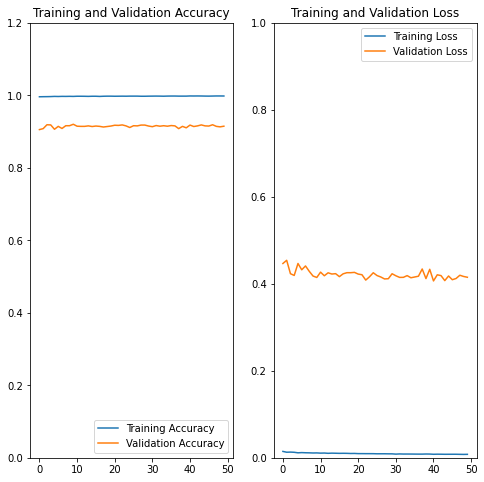

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0, 1.2])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Even more regularization  with more dropout layers

In [ ]:
num_classes = 9
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.07))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())



model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))

In [ ]:
## Your code goes here
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


281/281 [==============================] - 10s 32ms/step - loss: 1.5901 - accuracy: 0.4254 - val_loss: 2.7918 - val_accuracy: 0.1531
Epoch 2/50
281/281 [==============================] - 9s 31ms/step - loss: 1.2689 - accuracy: 0.5211 - val_loss: 3.4530 - val_accuracy: 0.1722
Epoch 3/50
281/281 [==============================] - 9s 31ms/step - loss: 1.1071 - accuracy: 0.5853 - val_loss: 1.5428 - val_accuracy: 0.4869
Epoch 4/50
281/281 [==============================] - 9s 31ms/step - loss: 0.9339 - accuracy: 0.6547 - val_loss: 2.8929 - val_accuracy: 0.3111
Epoch 5/50
281/281 [==============================] - 9s 31ms/step - loss: 0.7914 - accuracy: 0.7050 - val_loss: 2.0432 - val_accuracy: 0.4410
Epoch 6/50
281/281 [==============================] - 9s 31ms/step - loss: 0.6335 - accuracy: 0.7671 - val_loss: 2.1183 - val_accuracy: 0.4446
Epoch 7/50
281/281 [==============================] - 9s 31ms/step - loss: 0.5157 - accuracy: 0.8071 - val_loss: 1.0469 - val_accuracy: 0.6778
Epoch 8/5

### Learning Rate with Deacy

In [ ]:
num_classes = 9
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
#model.add(Dropout(0.03))

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.07))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))

In [ ]:
## Your code goes here
#opt = Adam(lr=0.001)
#model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#epochs = 25

history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/50
281/281 [==============================] - 10s 31ms/step - loss: 1.5452 - accuracy: 0.4343 - val_loss: 2.8961 - val_accuracy: 0.2457
Epoch 2/50
281/281 [==============================] - 8s 30ms/step - loss: 1.1294 - accuracy: 0.5792 - val_loss: 1.6081 - val_accuracy: 0.4829
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 0.9236 - accuracy: 0.6599 - val_loss: 1.3167 - val_accuracy: 0.5496
Epoch 4/50
281/281 [==============================] - 8s 30ms/step - loss: 0.7365 - accuracy: 0.7370 - val_loss: 2.5384 - val_accuracy: 0.4477
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.5867 - accuracy: 0.7923 - val_loss: 1.4166 - val_accuracy: 0.5607
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.4629 - accuracy: 0.8371 - val_loss: 0.6855 - val_accuracy: 0.7628
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.3760 - accuracy: 0.8712 - val_loss: 1.5377 - val_accuracy: 0.637

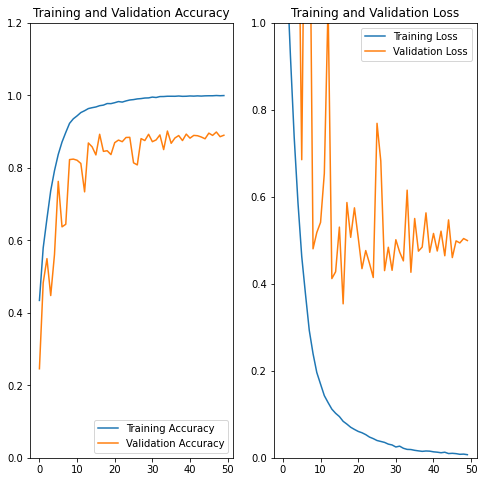

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0, 1.2])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
*   The model's overfitting reduced as droput is added. The difference between max train and test is 9% 
* Max accuracy of 0.9 achieved.

*   Mdel is more stable as the variation among test accuracy is very little

*  Model converged
* Learning rate decay solved the problem of unstable model
* Even SGD works with momentum

### Decreased momentum to 0.1

In [ ]:
## Your code goes here
#opt = Adam(lr=0.001)
#model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.1
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/50
281/281 [==============================] - 10s 31ms/step - loss: 1.4496 - accuracy: 0.4710 - val_loss: 4.4223 - val_accuracy: 0.1077
Epoch 2/50
281/281 [==============================] - 8s 30ms/step - loss: 1.0954 - accuracy: 0.5973 - val_loss: 2.0112 - val_accuracy: 0.4081
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 0.9172 - accuracy: 0.6714 - val_loss: 3.0178 - val_accuracy: 0.3169
Epoch 4/50
281/281 [==============================] - 8s 30ms/step - loss: 0.7960 - accuracy: 0.7233 - val_loss: 2.1358 - val_accuracy: 0.4263
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.6883 - accuracy: 0.7697 - val_loss: 2.2965 - val_accuracy: 0.4099
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.6072 - accuracy: 0.7984 - val_loss: 1.8147 - val_accuracy: 0.5247
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.5359 - accuracy: 0.8234 - val_loss: 2.3592 - val_accuracy: 0.421

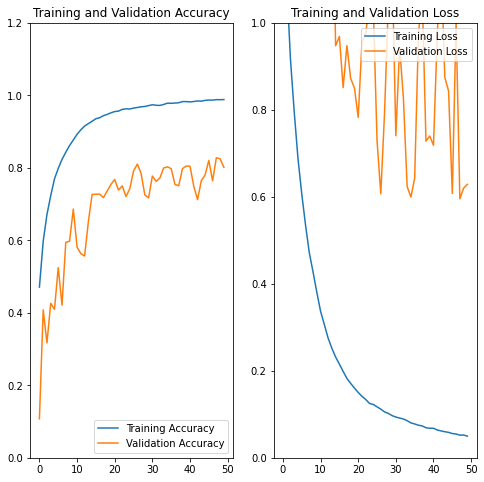

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0, 1.2])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
*   Decreasing momentum reduces model's accuracy to 0.83

*  Probably more training epochs can overcome this issue


In [ ]:
## Your code goes here
#opt = Adam(lr=0.001)
#model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.1
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/50
281/281 [==============================] - 10s 31ms/step - loss: 1.7759 - accuracy: 0.3857 - val_loss: 1.9070 - val_accuracy: 0.3115
Epoch 2/50
281/281 [==============================] - 8s 30ms/step - loss: 1.2458 - accuracy: 0.5321 - val_loss: 1.5413 - val_accuracy: 0.4548
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 1.0342 - accuracy: 0.6133 - val_loss: 1.1939 - val_accuracy: 0.5665
Epoch 4/50
281/281 [==============================] - 8s 30ms/step - loss: 0.8756 - accuracy: 0.6744 - val_loss: 1.1416 - val_accuracy: 0.5870
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.7327 - accuracy: 0.7349 - val_loss: 1.1561 - val_accuracy: 0.6199
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.6256 - accuracy: 0.7800 - val_loss: 0.9716 - val_accuracy: 0.6587
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.5230 - accuracy: 0.8222 - val_loss: 0.8360 - val_accuracy: 0.706

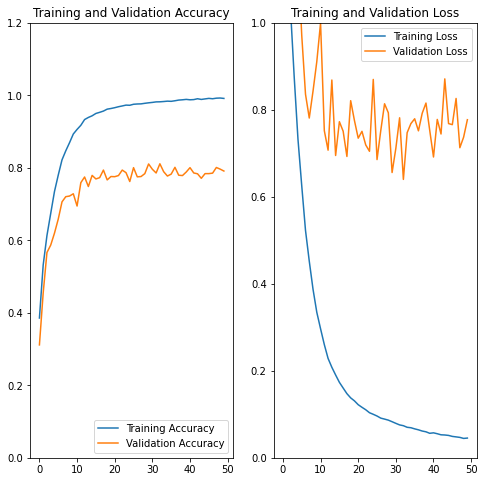

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0, 1.2])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
*   Learning rate decay stabulised the model
* Decreasing momentum resulted in only 0.82 % accuracy

*  But model is more stable

*  Increase in LR has no effect

### Keeping momentum at 0.8 and increasing LR to 0.1

In [ ]:
## Your code goes here
#opt = Adam(lr=0.001)
#model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/50
281/281 [==============================] - 10s 31ms/step - loss: 2.2408 - accuracy: 0.3162 - val_loss: 1.8359 - val_accuracy: 0.3249
Epoch 2/50
281/281 [==============================] - 8s 30ms/step - loss: 1.4256 - accuracy: 0.4669 - val_loss: 2.1999 - val_accuracy: 0.3240
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 1.2072 - accuracy: 0.5452 - val_loss: 1.5090 - val_accuracy: 0.4246
Epoch 4/50
281/281 [==============================] - 8s 30ms/step - loss: 1.0586 - accuracy: 0.6060 - val_loss: 1.5460 - val_accuracy: 0.4077
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.9350 - accuracy: 0.6514 - val_loss: 1.0810 - val_accuracy: 0.5990
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.8142 - accuracy: 0.7074 - val_loss: 1.1897 - val_accuracy: 0.5510
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.7185 - accuracy: 0.7423 - val_loss: 1.2144 - val_accuracy: 0.534

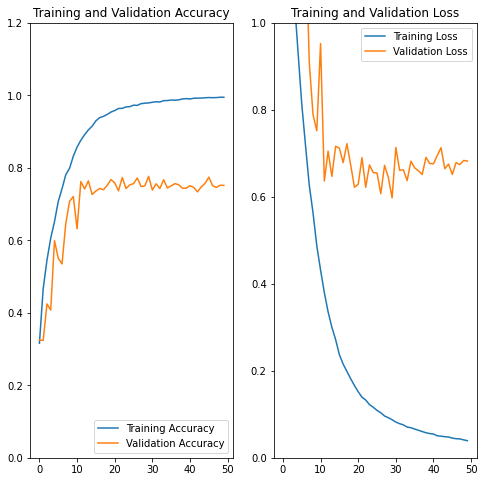

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0, 1.2])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

*  Increase in LR reduced the model's accuracy eventhough momentum is at 0.8.
* Model converged but accuracy decreased.
* Max test accuracy is 0.78

## Running the best model one more time

* With Batchnorm
* With Dropout
* With learning rate decay
* With SGD
* A model trained on balanced data
* A model with just 2.1 million parameters

In [ ]:
num_classes = 9
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))

model.add(Conv2D(16, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
#model.add(Dropout(0.03))

model.add(Conv2D(32, (3,3), dilation_rate=1, padding='same', input_shape=(img_height,img_width,3)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.03))
model.add(MaxPooling2D(pool_size=(2,2))) #90

model.add(Conv2D(64, (3,3), dilation_rate=1,  strides=1, input_shape=(90, 90, 32))) #88
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #44

model.add(Conv2D(128, (3,3), dilation_rate=1,  strides=1, input_shape=(44, 44, 64))) #42
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(42, 42, 128))) #40
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(MaxPooling2D(pool_size=(2,2))) #20

model.add(Conv2D(256, (3,3), dilation_rate=1,  strides=1, input_shape=(20, 20, 512))) #18
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.07))
model.add(Conv2D(512, (3,3), dilation_rate=1,  strides=1, input_shape=(19, 19, 256))) #9
model.add(ReLU())
model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size=7))# pool_size=9
model.add(Flatten())
model.add(Dense(num_classes))

In [ ]:
## Your code goes here
#opt = Adam(lr=0.001)
#model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/50
281/281 [==============================] - 9s 31ms/step - loss: 1.5437 - accuracy: 0.4356 - val_loss: 2.4210 - val_accuracy: 0.2394
Epoch 2/50
281/281 [==============================] - 8s 30ms/step - loss: 1.1519 - accuracy: 0.5698 - val_loss: 1.5110 - val_accuracy: 0.4793
Epoch 3/50
281/281 [==============================] - 8s 30ms/step - loss: 0.9609 - accuracy: 0.6436 - val_loss: 1.9426 - val_accuracy: 0.4566
Epoch 4/50
281/281 [==============================] - 8s 30ms/step - loss: 0.7901 - accuracy: 0.7106 - val_loss: 2.3283 - val_accuracy: 0.4250
Epoch 5/50
281/281 [==============================] - 8s 30ms/step - loss: 0.6340 - accuracy: 0.7756 - val_loss: 1.1505 - val_accuracy: 0.6142
Epoch 6/50
281/281 [==============================] - 8s 30ms/step - loss: 0.5139 - accuracy: 0.8191 - val_loss: 2.8837 - val_accuracy: 0.4157
Epoch 7/50
281/281 [==============================] - 8s 30ms/step - loss: 0.4157 - accuracy: 0.8541 - val_loss: 0.9737 - val_accuracy: 0.6489

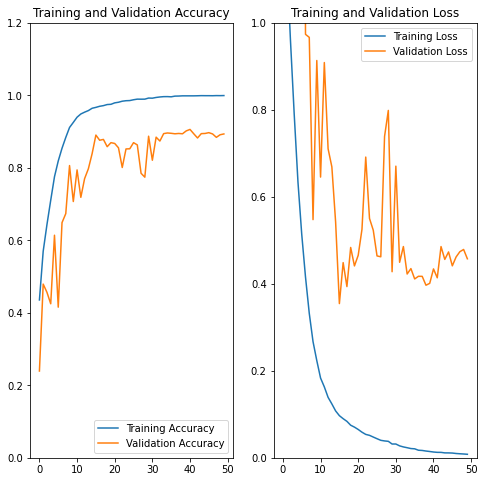

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0, 1.2])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Best Model Metrics
* Best Test accuracy of 90.61
* Best acuracy obtained at epoch 42
* Model converged but slighlt overfitting